# **Sistem Rekomendasi Film - Netflix**

- **Nama:** Duma Mora Arta Sitorus
- **Email:** dumamora5@gmail.com
- **ID Dicoding:** duma_mora

## Import Library

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## Data Understanding

Dataset yang digunakan pada proyek ini diperoleh dari public reposiitory Kaggle yang dapat diakses melalui tautan berikut: [movie recommender dataset](https://www.kaggle.com/datasets/gargmanas/movierecommenderdataset)

Dataset movie recommender terdiri dari atas 2 file terpisah yaitu movie dan rating.

In [ ]:
movie = pd.read_csv("https://raw.githubusercontent.com/DumaSitorus/movie-recommender-system/refs/heads/main/dataset/movies.csv")
rating = pd.read_csv("https://raw.githubusercontent.com/DumaSitorus/movie-recommender-system/refs/heads/main/dataset/ratings.csv")

## Exploratory Data Analysis

Tahap Exploratory Data Analysis bertujuan untuk melakukan analisis dan eksplorasi terhadap variabel pada data.

### Movie

In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
movie.sample(10)

,movieId,title,genres
9679,183301,The Tale of the Bunny Picnic (1986),Children
8089,100106,"Pervert's Guide to Ideology, The (2012)",Documentary
2754,3692,Class of Nuke 'Em High (1986),Comedy|Horror
1689,2271,Permanent Midnight (1998),Drama
7241,73858,"Dennis the Menace Christmas, A (2007)",Comedy
3481,4750,3 Ninjas Knuckle Up (1995),Action|Children
9318,159817,Planet Earth (2006),Documentary
2307,3057,Where's Marlowe? (1998),Comedy
9158,148238,A Very Murray Christmas (2015),Comedy
8515,114246,"Walk Among the Tombstones, A (2014)",Action|Crime|Mystery|Thriller


In [ ]:
print('Banyak genres: ', len(movie.genres.unique()))
print('Tipe masakan: ', movie.genres.unique())

Banyak genres:  951
Tipe masakan:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Children|Comedy' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Drama|Thriller'
 'Comedy|Crime' 'Action|Sci-Fi|Thriller' 'Action|Comedy|Horror|Thriller'
 'Comedy|Drama' 'Documentary' 'Action|Crime|Drama|Thriller'
 'Crime|Drama|Romance' 'Action|Adventure|Drama' 'Action|Thriller'
 'Drama|Horror

**Hasil analisis data movie:**

Data `movie` terdiri dari tiga buah kolom yaitu:

1. `movieId`
  - kolom ini berisikan nomor identifikasi unik yang membedakan setiap data movie.
  - kolom `movieId` bertipe integer dan tidak memiliki *missing value*

2. `title`
  - kolom ini berisikan data judul film yang tersusun oleh `judul + (tahun tayang)`
  -  kolom `title` bertipe object dan tidak memiliki *missing value*

3. `genres`
  - kolom ini berisikan data berupa genre atau jenis film atau movie.
  -  kolom `genres` bertipe object dan tidak memiliki *missing value*
  - terdapat 951 data genre unik pada data movie dengan berbagai kombinasi dari 20 genre film yang ada. yaitu `action`, `adventure`, `animation`, `children`, `comedy`, `crime`, `documentary`, `drama`, `fantasy`, `film`, `horror`, `imax`, `musical`, `mystery`, `noir`, `romance`, `Sci-Fi`, `thriller`, `war`, `western`
  - terdapat film dengan genre yang tidak memiliki nilai tetapi diisi dengan teks `(no genres listed)`

---
Berdasarkan hasil analisis tersebut, diperlukan perbaikan untuk data movie sebagai berikut:
1. Data pada kolom `title` perlu dipisahkan antara judul dengan tahun tayang agar tidak memberikan representasi yang berbeda pada dua atau lebih film yang sama dengan tahun tayang yang berbeda ketika diterapkan TF-IDF.

2. Perlu perbaikan pada salah satu genre yaitu Sci-Fi yang merujuk pada genre Science Fiction. Penggunaan tanda hubunga (karakter '-') dapat memberikan representasi yang berbeda pada dua kata yaitu Sci dan Fi pada saat penggunaan TF-IDF yang menganggap katakter '-' sebagai pemisah antar kata.

3. Diperlukan penanganan pada data movie dengan genre yang kosong atau berikan `(no genres listed)`. Solusi yang dapat diberikan dapat berupa drop data jika data tidak terlalu banyak.

### Rating

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
rating.sample(10)

,userId,movieId,rating,timestamp
33875,231,296,4.0,1433089540
22961,156,2926,3.0,946799400
30546,213,3285,4.0,1316194631
49465,318,53972,3.5,1413054690
46098,305,2411,5.0,1518858703
5706,41,2160,5.0,1459368424
26576,182,3052,2.5,1054784162
2493,19,1240,4.0,965703605
40922,275,4886,4.0,1049077518
40906,275,4345,5.0,1049077696


In [ ]:
rating.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
print("Jumlah user yang memberi rating pada movie: ", len(rating.userId.unique()))
print("Jumlah movie yang diberi rating: ", len(rating.movieId.unique()))
print("Jumlah keseluruhan data rating: ", len(rating))

Jumlah user yang memberi rating pada movie:  610
Jumlah movie yang diberi rating:  9724
Jumlah keseluruhan data rating:  100836


**Hasil analisis data rating:**

Data `rating` terdiri dari empat buah kolom yaitu:

1. `userId`
  - kolom ini berisikan nomor identifikasi pengguna yang memberikan rating pada film
  - kolom `userId` bertipe integer dan tidak memiliki *missing value*
  - terdapat total 610 pengguna yang memberikan rating terhadap film

2. `movieId`
  - kolom ini berisikan nomor identifikasi film yang telah diberikan rating oleh pengguna
  -  kolom `movieId` bertipe integer dan tidak memiliki *missing value*
  - terdapat 9724 film yang telah diberikan rating oleh pengguna

3. `rating`
  - kolom ini berisikan data rating pengguna terhadap film
  -  kolom `rating` bertipe float dan tidak memiliki *missing value*
  - kolom `rating` memiliki nilai dari 0.5 hingga 5. sehingga terdapat 10 nilai unik untuk rating.
  - total keseluruhan aktivitas rate film yang tercatat pada data berjumlah 100836

4. `timestamp`
  - kolom ini berisikan data berupa timestamp atau waktu ketika data dimasukkan kedalam basis data.
  -  kolom `timestamp` bertipe integer dan tidak memiliki *missing value*

---
Berdasarkan hasil analisis tersebut, tidak terdapat permasalahan dalam dataset tersebut sehingga tidak perlu dilakukan penanganan apapun pada tahap preprocessing.

## Data Preprocessing

Ini merupakan tahap persiapan data sebelum data digunakan untuk proses selanjutnya. Pada tahap ini, dilakukan dengan penggabungan beberapa file sehingga menjadi satu kesatuan file yang utuh dan siap digunakan dalam tahap pemodelan.

In [ ]:
df = rating.merge(movie, on='movieId')

In [ ]:
df.sample(10)

,userId,movieId,rating,timestamp,title,genres
36704,249,5679,3.5,1415415314,"Ring, The (2002)",Horror|Mystery|Thriller
16527,105,8984,4.0,1446749865,Ocean's Twelve (2004),Action|Comedy|Crime|Thriller
35909,244,1527,4.0,975092819,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi
76339,480,832,2.5,1179178449,Ransom (1996),Crime|Thriller
34998,234,1573,4.0,1004408226,Face/Off (1997),Action|Crime|Drama|Thriller
7088,48,6333,3.5,1127128894,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller
91644,594,4054,4.5,1108976081,Save the Last Dance (2001),Drama|Romance
7691,51,4308,0.5,1230929415,Moulin Rouge (2001),Drama|Musical|Romance
87764,566,380,3.0,849005103,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
84584,543,48385,5.0,1230602124,Borat: Cultural Learnings of America for Make ...,Comedy


In [ ]:
df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


In [ ]:
print("jumlah data duplikat:", df.duplicated().sum())

jumlah data duplikat: 0


In [ ]:
len(df[df['genres'] == '(no genres listed)'])

47

**Catatan untuk proses Preprocessing:**

Tahap data preprocessing dilakukan dengan menggabungkan data movie dan rating kedalam dataframe. Berikut adalah rincian langkah yang telah dilakukan pada tahapan ini:

1. Menggabungkan tabel rating dengan tabel movie berdasarkan movieId ke dalam sebuah dataframe bernama `df`.
2. Melakukan pengecekan apakah terdapat missing value pada data setelah dilakukan merging. Hasil yang diberikan yaitu tidak ada missing value, sehingga tidak perlu dilakukan penanganan missing value.
3. Mengecekan apakah terdapat dupliaksi pada data setelah dilakukan merging. Hasil yang diberikan yaitu tidak terdapat duplikasi, sehingga tidak perlu dilakukan penanganan duplicated data.

4. Mengecek apakah terdapat invalid value pada kolom genre. Dan, Ya terdapat genre yang bernilai (no genres listed). hal ini perlu penanganan lebih lanjut untuk menghasilkan data yang bermakna.

## Data Preparation

Pada tahap ini, dilakukan persiapan data dan melakukan beberapa teknik seperti mengatasi missing value dan solusi lainnya untuk menghasilkan data yang berkualitas.

**Catatan untuk proses Preparation:**

Tahapan preparation bertujuan untuk mempersiapkan dataset agar bersih dan siap untuk masuk ke tahap pengembangan model sistem rekomendasi. Adapun langkah yang dilakukan pada tahapan ini antara lain:

1. Menangani (data no genres listed) pada kolom genres. Solusi penanganan yang diberikan yaitu drop data, jumlah data dengan value (data no genres listed) hanya 47 buah, yang mana ini terbilang sedikit dari keseluruhan data yang berjumlah 100836.
2. Memisahkan title dan tahun tayang movie menggunakan regular expression. Title akan tetap berada di kolom title sedangkan tahun tayang movie akan dipindahkan ke kolom year.
3. Menangani karakter '|' dan genre 'Sci-Fi' pada kolom genres. Penanganan ini dilakukan dengan menggunakan regular ekspression/ karakter '|' akan dihapus dan diganti dengan karakter space (' ') dan genre dengan value 'Sci-Fi' diganti dengan 'SciFi'.

### Menangani (data no genres listed) pada kolom genres

In [ ]:
df = df[df['genres'] != '(no genres listed)']
print("no genres listed movie:", len(df[df['genres'] == '(no genres listed)']))

no genres listed movie: 0


In [ ]:
df['genres'] = df['genres'].str.replace('|', ' ', regex=False)
df.sample(10)

,userId,movieId,rating,timestamp,title,genres,year
9955,65,4993,3.5,1494767062,"Lord of the Rings: The Fellowship of the Ring,...",Adventure Fantasy,2001
49539,318,65225,4.5,1315335401,Zeitgeist: Addendum,Documentary,2008
52966,348,4865,5.0,1378849974,From Hell,Crime Horror Mystery Thriller,2001
58901,384,457,4.0,994038410,"Fugitive, The",Thriller,1993
21312,140,2490,4.0,951163625,Payback,Action Thriller,1999
34860,233,60069,4.0,1472587437,WALL·E,Adventure Animation Children Romance Sci-Fi,2008
26750,182,4146,4.0,1075765191,"Million Dollar Hotel, The",Drama Mystery Romance,2001
26235,182,999,3.5,1075764968,2 Days in the Valley,Crime Film-Noir,1996
24225,167,45722,3.5,1154721497,Pirates of the Caribbean: Dead Man's Chest,Action Adventure Fantasy,2006
15224,98,88810,4.0,1532457903,"Help, The",Drama,2011


In [ ]:
df['genres'] = df['genres'].str.replace('Sci-Fi', 'SciFi', regex=False)

scifi_movies = df[df['genres'].str.contains('SciFi')]
scifi_movies.sample(10)

,userId,movieId,rating,timestamp,title,genres,year
96921,603,3576,4.0,963176318,"Hidden, The",Action Horror SciFi,1987
35637,240,329,3.0,849122165,Star Trek: Generations,Adventure Drama SciFi,1994
99172,608,3527,3.0,1117162141,Predator,Action SciFi Thriller,1987
100374,610,68319,1.0,1493845505,X-Men Origins: Wolverine,Action SciFi Thriller,2009
98775,608,541,3.5,1117490759,Blade Runner,Action SciFi Thriller,1982
6072,42,1726,2.0,996221012,"Postman, The",Action Adventure Drama SciFi,1997
28318,197,924,4.0,947462579,2001: A Space Odyssey,Adventure Drama SciFi,1968
32122,220,2012,4.5,1230061526,Back to the Future Part III,Adventure Comedy SciFi Western,1990
34793,233,1921,3.5,1529334433,Pi,Drama SciFi Thriller,1998
50497,326,2571,3.5,1419880534,"Matrix, The",Action SciFi Thriller,1999


### Memisahkan title dan tahun tayang movie

In [ ]:
movie['year'] =  movie['title'].str.extract(r'\((\d{4})\)')
movie['title'] =  movie['title'].str.replace(r'\((\d{4})\)', '', regex=True).str.strip()

movie.sample(10)

,movieId,title,genres,year
3708,5113,After the Fox (Caccia alla volpe),Comedy|Crime,1966
6085,41828,Don't Look Now: We're Being Shot At (La grande...,Comedy|War,1966
34,38,It Takes Two,Children|Comedy,1995
8549,115680,Time Lapse,Crime|Drama|Sci-Fi|Thriller,2014
4583,6809,Tightrope,Thriller,1984
6794,60538,Shrooms,Horror|Thriller,2007
2502,3344,Blood Feast,Horror,1963
2423,3223,"Zed & Two Noughts, A",Drama,1985
9148,147378,Doctor Who: Planet of the Dead,Adventure|Children|Drama|Sci-Fi,2009
7038,68952,Drag Me to Hell,Comedy|Horror,2009


### Menanganai karakter '|' dan genre Sci-Fi pada kolom genres

In [ ]:
movie['genres'] = movie['genres'].str.replace('|', ' ', regex=False)
movie['genres'] = movie['genres'].str.replace('Sci-Fi', 'SciFi', regex=False)

scifi_movie = movie[movie['genres'].str.contains('SciFi')]
scifi_movie.sample(10)

,movieId,title,genres,year
3606,4953,"People That Time Forgot, The",Adventure SciFi,1977
2008,2672,"Thirteenth Floor, The",Drama SciFi Thriller,1999
2183,2900,Monkey Shines,Horror SciFi,1988
9548,172887,Kid's Story,Animation SciFi,2003
8690,122902,Fantastic Four,Action Adventure Fantasy SciFi,2015
1926,2554,Children of the Damned,Horror SciFi Thriller,1963
6876,62834,Babylon 5: The Legend of the Rangers: To Live ...,SciFi,2002
7438,80969,Never Let Me Go,Drama Romance SciFi,2010
6791,60514,Journey to the Center of the Earth,Action Adventure SciFi,2008
3873,5445,Minority Report,Action Crime Mystery SciFi Thriller,2002


In [ ]:
len(movie[movie['genres'] == '(no genres listed)'])

34

In [ ]:
movie = movie[movie['genres'] != '(no genres listed)']
print("no genres listed movie:", len(movie[movie['genres'] == '(no genres listed)']))

no genres listed movie: 0


### Data Preparation untuk pengembangan sistem rekomendasi dengan pendekatan content based filtering



#### Menyiapakan data

In [ ]:
# data movie yang telah melewati tahapan preprocessing
data = movie
data.sample(5)

,movieId,title,genres,year
7888,94864,Prometheus,Action Horror SciFi IMAX,2012
2537,3397,"Great Muppet Caper, The",Children Comedy,1981
3087,4144,In the Mood For Love (Fa yeung nin wa),Drama Romance,2000
42,46,How to Make an American Quilt,Drama Romance,1995
5375,8964,Callas Forever,Drama,2002


Data yang digunakan merupakan data movie yang telah dibersihkan pada tahap preprocessing. Penggunaan data ini karena kita ingin mempertimbangkan rekomendasi film berdasarkan kemiripan genres antar film.

#### TF-IDF Vectorizer

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genres
tf.fit(data['genres'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'scifi', 'thriller',
       'war', 'western'], dtype=object)

In [ ]:
tfidf_matrix = tf.fit_transform(data['genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9708, 20)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.4168036 , 0.51628768, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51229321, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.5784593 , 0.        , 0.81571125, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre movie
# Baris diisi dengan judul movie

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.title
).sample(20, axis=1).sample(10, axis=0)

,drama,horror,film,noir,comedy,children,fantasy,war,scifi,imax,musical,animation,western,mystery,romance,documentary,adventure,action,crime,thriller
title,,,,,,,,,,,,,,,,,,,,
Spirits of the Dead,0.000000,0.652272,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.757985,0.000000,0.0,0.0,0.000000,0.0,0.000000
Swimming Pool,0.361237,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.768214,0.000000,0.0,0.0,0.000000,0.0,0.528541
Pocahontas,0.236584,0.000000,0.0,0.0,0.00000,0.483784,0.000000,0.0,0.0,0.0,0.573897,0.494699,0.0,0.000000,0.368642,0.0,0.0,0.000000,0.0,0.000000
Insidious,0.000000,0.599550,0.0,0.0,0.00000,0.000000,0.640907,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.479351
"OH in Ohio, The",0.000000,0.000000,0.0,0.0,1.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
Torn Curtain,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
Edmond,0.564262,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.825596
Driven,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.711818,0.0,0.702364
Victor/Victoria,0.000000,0.000000,0.0,0.0,0.35163,0.000000,0.000000,0.0,0.0,0.0,0.787642,0.000000,0.0,0.000000,0.505940,0.0,0.0,0.000000,0.0,0.000000


Output diatas merupakan hasil matriks tf-idf yang dihitung sebelumnya. baris mewakili item atau film sedangkan kolom berisikan kata-kata unik dari genres. Nilai yang terdapat pada baris dan kolom tertentu merupakan representasi seberapa penting genre dalam sebuah film.

Jadi intinya hasil perhitungan TF-IDF memberikan representasi numerik yang mengindikasikan pentingnya kata-kata dalam judul atau genre secara relatif.

### Data Preparation untuk pengembangan sistem rekomendasi dengan pendekatan collaborative filtering



#### Data Preparation: Maping Id, Pengacakan Dataset, Normalisasi Rating

In [ ]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [432, 288, 599, 42, 75, 51, 354, 416, 438, 73, 567, 391, 380, 305, 409, 307, 274, 125, 561, 68, 525, 414, 6, 601, 325, 82, 16, 542, 32, 140, 182, 89, 359, 183, 111, 80, 448, 514, 509, 131, 45, 156, 440, 312, 57, 603, 337, 116, 122, 201, 167, 139, 450, 178, 581, 215, 610, 81, 340, 323, 232, 186, 28, 195, 596, 602, 202, 200, 387, 510, 290, 221, 598, 34, 62, 137, 606, 352, 572, 129, 279, 428, 152, 328, 427, 367, 560, 19, 474, 189, 556, 3, 1, 217, 282, 310, 91, 103, 566, 298, 381, 292, 43, 50, 46, 564, 382, 48, 338, 475, 7, 469, 256, 132, 480, 227, 226, 368, 587, 488, 135, 535, 529, 14, 534, 29, 21, 112, 502, 339, 27, 608, 187, 551, 285, 370, 481, 379, 212, 160, 121, 437, 577, 562, 477, 213, 590, 259, 222, 105, 309, 246, 248, 332, 303, 600, 489, 306, 4, 58, 76, 418, 64, 457, 287, 39, 18, 146, 24, 410, 169, 522, 219, 141, 230, 462, 199, 445, 317, 355, 453, 472, 594, 369, 357, 280, 494, 239, 452, 66, 580, 586, 517, 220, 479, 41, 313, 420, 597, 405, 495, 441, 100, 593, 30, 351, 

In [ ]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

In [ ]:
# Mapping userID ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah movie
num_movie = len(movie_encoded_to_movie)
print(num_movie)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9724
Number of User: 610, Number of movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Data preparation ini berguna untuk melakukan encoding pada movieId dan userId. setelah itu, hasil encoding akan disimpan di dalam kolom movie dan user.

#### Data Splitting

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
39920,274,4683,4.0,1172275751,16,8309
31097,217,1259,3.0,955941925,93,522
27388,186,1376,5.0,1031079628,61,1331
35836,243,356,4.0,837155178,559,48
12082,74,3273,2.5,1207499293,275,288
...,...,...,...,...,...,...
99583,610,784,5.0,1479544723,56,174
91864,596,3000,5.0,1535708657,64,654
59035,385,500,3.0,834694199,301,824
25661,177,70159,2.5,1435838020,269,690


In [ ]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  16 8309]
 [  93  522]
 [  61 1331]
 ...
 [ 301  824]
 [ 269  690]
 [ 416 4379]] [0.77777778 0.55555556 1.         ... 0.55555556 0.44444444 0.55555556]


Data splitting berguna untuk membagi data menjadi data train dan data test. keseluruhan data akan dibagi menjadi X dan y. X berisi data user dan movie sedangkan y berisi berisi data rating pengguna terhadap movie. Pembagian data train dan test menggunakan rasio 80:20.

## Model Development



### Content Based Filtering

Pada tahap inilah dilakukan pengembangkan sistem rekomendasi dengan teknik content based filtering. Teknik content based filtering akan merekomendasikan item yang mirip dengan item yang disukai pengguna di masa lalu. Pada tahap ini.Pada tahapan ini akan menggunakan teknik menemukan representasi fitur penting dari setiap kategori movie dengan tfidf vectorizer dan menghitung tingkat kesamaan dengan cosine similarity. Setelah itu, dilakukan pembuatan sejumlah rekomendasi movie berdasarkan kesamaan yang telah dihitung sebelumnya.

#### Cosine Similarity

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.8136036 , 0.15259961, ..., 0.        , 0.42114166,
        0.26738778],
       [0.8136036 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15259961, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57070525],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42114166, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26738778, 0.        , 0.57070525, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa title movie
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap movie
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9708, 9708)


title,Repossessed,Santa Sangre,Kung Fu Panda 2,Gremlins 2: The New Batch,Fame
title,,,,,
"Mudge Boy, The",0.000000,0.301343,0.000000,0.000000,0.381126
Central Intelligence,0.589780,0.000000,0.384216,0.300360,0.000000
That Darn Cat,0.344586,0.433644,0.356494,0.175489,0.000000
High Anxiety,0.594921,0.354394,0.134811,0.302978,0.000000
Only the Strong,0.000000,0.000000,0.310279,0.000000,0.000000
Peter Pan,0.000000,0.000000,0.234745,0.000000,0.601688
In July (Im Juli),0.570705,0.000000,0.129323,0.290645,0.000000
Titan A.E.,0.000000,0.000000,0.691389,0.000000,0.000000
Karlson Returns,0.000000,0.000000,0.706607,0.000000,0.000000


Nilai dari matrix TF-IDF yang telah diperoleh sebelumnya dapat digunakan untuk menghitung Cosine Similarity. Cosine Similarity menghitung seberapa mirip dua vektor, misalnya, vektor TF-IDF dari dua film berdasarkan sudutnya. Vektor dengan nilai TF-IDF yang lebih besar pada kata-kata yang relevan akan menghasilkan nilai cosine similarity yang lebih tinggi, dimana ini berarti mereka lebih mirip.

Sehingga dari perhitungan cosine similarity diperoleh hasil berupa hasil pengukuran kemiripan antara setiap film. Nilai ini yang dipertimabngkan oleh sistem rekomendasi untuk menentukan film yang mirip satu-sama lain.

#### Mendapatkan Rekomendasi

In [ ]:
def movie_recommendations(movie_title, similarity_data=cosine_sim_df, items=data[['title', 'genres']], k=5):
    """
    Rekomendasi movie berdasarkan kemiripan dataframe

    Parameter:
    ---
    movie_title : tipe data string (str)
                Judul movie (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan movie sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,movie_title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop movie_title agar judul movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(movie_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
data[data.title.eq('Kung Fu Panda')]

,movieId,title,genres,year
6760,59784,Kung Fu Panda,Action Animation Children Comedy IMAX,2008


In [ ]:
movie_recommendations('Kung Fu Panda')

,title,genres
0,Despicable Me 2,Animation Children Comedy IMAX
1,Happy Feet Two,Animation Children Comedy IMAX
2,Kung Fu Panda 2,Action Adventure Animation Children Comedy IMAX
3,Megamind,Action Animation Children Comedy SciFi IMAX
4,Madagascar: Escape 2 Africa,Action Adventure Animation Children Comedy IMAX


Yeay, hasil rekomendasi film telah berhasil diperoleh.

---

Hasil tersebut diperoleh dengan terlebih dahulu membuat fungsi movie_recommendations yang akan mengembalikan top-N recomendation yang mirip dengan judul movie yang diinputkan. Tidak lupa dilakukan Drop movie title yang diinputkan pada fungsi agar judul movie yang dicari tidak muncul dalam daftar rekomendasi

### Collaborative Filtering

Pada pendekatan ini, akan menghasilkan mode yang mampu memberikan rekomendasi film atau movie berdasarkan rating yang pengguna sebelumnya. Melalui data rating pengguna akan diidentifikasi sekumpulan film yang mirip dan belum pernah berinteraksi sebelumnya oleh pengguna untuk direkomendasikan.

#### Modelling

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

In [ ]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 15,
    validation_data = (x_val, y_val),
)

Epoch 1/15
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.6176 - root_mean_squared_error: 0.2089 - val_loss: 0.6178 - val_root_mean_squared_error: 0.2078
Epoch 2/15
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.6122 - root_mean_squared_error: 0.2021 - val_loss: 0.6130 - val_root_mean_squared_error: 0.2043
Epoch 3/15
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.6092 - root_mean_squared_error: 0.2010 - val_loss: 0.6133 - val_root_mean_squared_error: 0.2038
Epoch 4/15
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.6036 - root_mean_squared_error: 0.1933 - val_loss: 0.6121 - val_root_mean_squared_error: 0.2034
Epoch 5/15
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.6036 - root_mean_squared_error: 0.1953 - val_loss: 0.6122 - val_root_mean_squared_error: 0.2026
Epoch 6/15
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.6027 - root_mean_squared_error: 0.1918 - val_loss: 0.6098 - val_root_mean_squared_error: 0.2009
Epoch 7/15
2521/2521 ━━━━━━━━

#### Evaluasi dengan Visualisasi Metrik

Untuk melihat visualisasi proses training, mari kita plot metrik evaluasi dengan matplotlib.

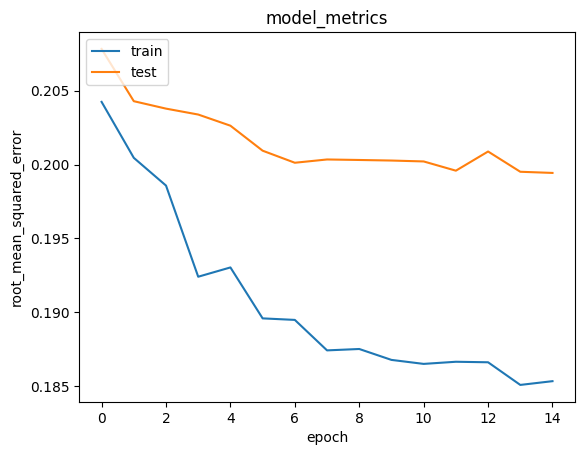

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Berdasarkan hasil plot tersebut, terlihat bahwa nilai Root Mean Squere Error terus menurun seiring bertambahnya epoch dengan nilai error  akhir sebesar 0.1867 untuk pelatihan dan 0.1994 untuk test.

#### Mendapatkan rekomendasi Movie

Pada tahapan ini akan dilakukan percobaan untuk memperoleh hasil rekomendasi untuk sampel user. Hasil rekomendasi akan memberikan judul film yang pernah dirating dengan nilai tinggi oleh user tersebut, kemudian menampilkan rekomendasi film berdasarkan preferensi dan rating para pengguna.

In [ ]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
movie_id = movie['movieId'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
movie_title = movie['title'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
movie_genres = movie['genres'].tolist()

print(len(movie_id))
print(len(movie_title))
print(len(movie_genres))

9708
9708
9708


In [ ]:
movie_df = pd.DataFrame({
    'id': movie_id,
    'movie_title': movie_title,
    'genres': movie_genres
})

In [ ]:
movie_df.sample(10)

,id,movie_title,genres
3358,4562,Without a Clue,Comedy Mystery
781,1023,Winnie the Pooh and the Blustery Day,Animation Children Musical
6102,42559,Samurai Assassin (Samurai),Action Adventure Drama
8513,114180,"Maze Runner, The",Action Mystery SciFi
5024,7812,Babylon 5: Thirdspace,Drama SciFi
9252,157108,Texas - Doc Snyder hält die Welt in Atem,Comedy Western
9634,182639,The Second Renaissance Part II,Animation SciFi
6246,46850,Wordplay,Documentary
9315,160565,The Purge: Election Year,Action Horror SciFi
2242,2977,Crazy in Alabama,Comedy Drama


In [ ]:
# df = pd.read_csv('rating_final.csv')
df = pd.read_csv("https://raw.githubusercontent.com/DumaSitorus/movie-recommender-system/refs/heads/main/dataset/ratings.csv")

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_to_movie_encoded.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('\n')
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_title, ':', row.genres)

print('\n')
print('----' * 8)
print('Top-n movie recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_title, ':', row.genres)

299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Showing recommendations for users: 230


Movie with high ratings from user
--------------------------------
Fifth Element, The : Action Adventure Comedy SciFi
Pirates of the Caribbean: The Curse of the Black Pearl : Action Adventure Comedy Fantasy
Pirates of the Caribbean: Dead Man's Chest : Action Adventure Fantasy
Transformers : Action SciFi Thriller IMAX
Mr. Woodcock : Comedy


--------------------------------
Top 10 movie recommendation
--------------------------------
Under Siege 2: Dark Territory : Action
Soul Man : Comedy
Immigrant, The : Comedy


Dari hasil tersebut, terlihat bahwa model telah berhasil memberikan daftar rekomendasi beberapa film yang belum pernah ditonton oleh pengguna berdasarkan rating pengguna terhadap film sebelumnya. Pada hasil yang diberikan tidak menampilkan Top-10 melainkan hanya 3 saja, ini kemungkinan terjadi karena film yang yang direkomendasikan telah ditonton sebelumnya oleh pengguna tersebut.

## Consclusion
Pada proyek pengembangan sistem rekomendasi film ini, saya telah berhasil membuat sistem rekomendasi dengan pendekatan Content based Filtering dan Collaborative Filtering. Sistem rekomendasi dengan pendekatan Content based Filtering telah berhasil memberikan top-5 rekomendasi film yang mirip berdasarkan judul dan genre film tersebut.

Kemudian, untuk dengan penekatan Collaborative Filtering telah berhasil melatih model yang mampu memberikan rekomendasi film berdasarkan preferensi pengguna seperti rating terhadap film.

Konsep pada proyek ini dapat diimplementasikan dengan menyesuaikan data mengingat industri film terus meproduksi film setiap waktu sehingga perlu penyesuaian dataset.